In [1]:
#필요한 패키지 임포트
import pandas as pd
import numpy as np
import librosa
from glob import glob
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

**비정형 데이터의 EDA**

In [2]:
#고양이 음성 파일 위치 불러오기
base_dir = '/catclass/augmented_data/unstructured_data/train/meow/'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp

파일의 확장자는 무엇인가?

In [10]:
#파일의 확장자 알아보기
print(train_path[0].split('.')[-1])

wav


파일의 길이, 샘플링 레이트는 무엇인가?

In [18]:
#파일의 길이, 샘플링 레이트 알아보기
print('length : '+str(librosa.get_duration(path='/catclass/-46xqouqMxA_6.wav'))+' sec')
print('sampling rate : '+str(librosa.get_samplerate(path='/catclass/-46xqouqMxA_6.wav'))+' kHz')

length : 9.170125 sec
sampling rate : 16000 kHz


파일의 음성 파형은 어떤 모양인가?

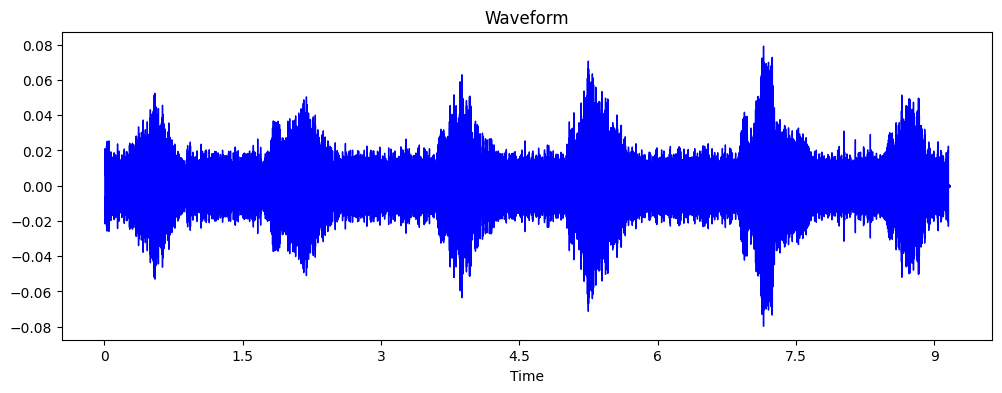

In [25]:
#원본 데이터의 파형
y,sr = librosa.load("/catclass/-46xqouqMxA_6.wav")
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr,  color="blue")
plt.title('Waveform')
plt.show()

원본 데이터의 Spectrogram은 무엇인가?

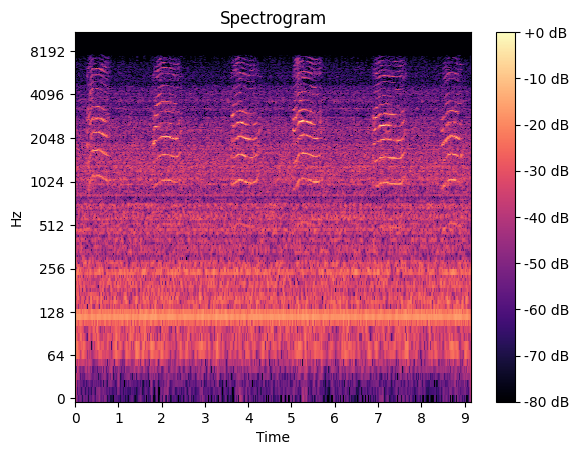

In [20]:
#원본 데이터의 Spectrogram
y, sr = librosa.load('/catclass/-46xqouqMxA_6.wav')
spec = np.abs(librosa.stft(y, hop_length=512))
spec = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec, sr=sr, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');
plt.title('Spectrogram');

원본 데이터의 특징적인 값들은 무엇인가? (MFCC)

In [32]:
#mfcc 얻기
mfccs = librosa.feature.mfcc(y=y,sr=sr)
print(mfccs)

[[-405.77493   -383.97314   -386.87177   ... -397.99      -391.22617
  -404.2927   ]
 [ 156.04315    173.11053    180.70786   ...  165.21657    167.02975
   161.49443  ]
 [ -48.253227   -61.61284    -61.68759   ...  -72.13669    -73.36633
   -58.817764 ]
 ...
 [  -1.8358481   -2.9163232    2.3762558 ...    1.1091645   -4.3528214
    -5.0962105]
 [   1.9168429   -2.5084913   -6.9677377 ...  -10.139533    -7.806323
    -5.73901  ]
 [  -6.703021    -8.358321   -10.244764  ...   -1.7410345   -1.1825583
     3.2978601]]


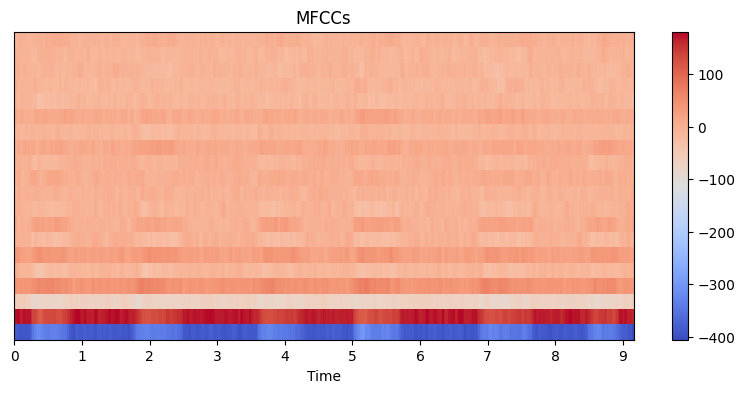

In [30]:
#mfcc 시각화하기
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCCs')
plt.show()

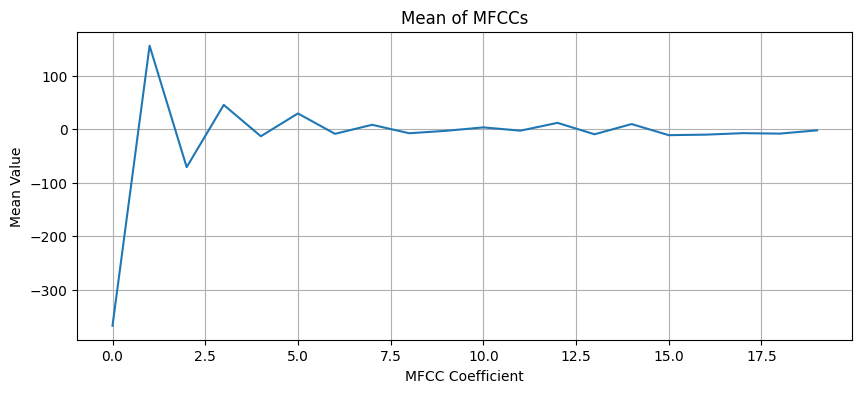

In [42]:
#mfcc의 평균을 구한 후 시각화한다
mean_mfccs = np.mean(mfccs, axis=1)
plt.figure(figsize=(10, 4))
plt.plot(mean_mfccs)
plt.xlabel('MFCC Coefficient')
plt.ylabel('Mean Value')
plt.title('Mean of MFCCs')
plt.grid(True)
plt.show()

<Axes: >

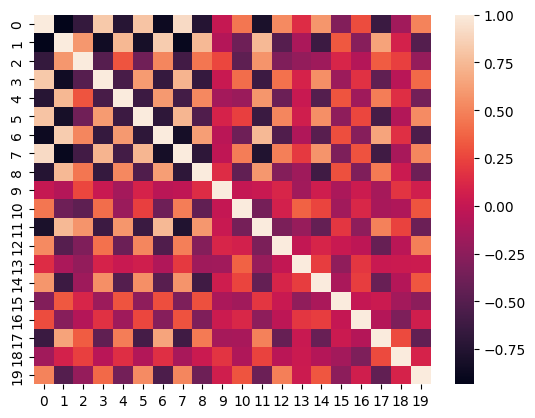

In [38]:
#mfcc의 corr 구하기
correlation_matrix = np.corrcoef(mfccs)
sns.heatmap(correlation_matrix)

데이터에게 영향을 주는 요인으로는 무엇이 있는가?

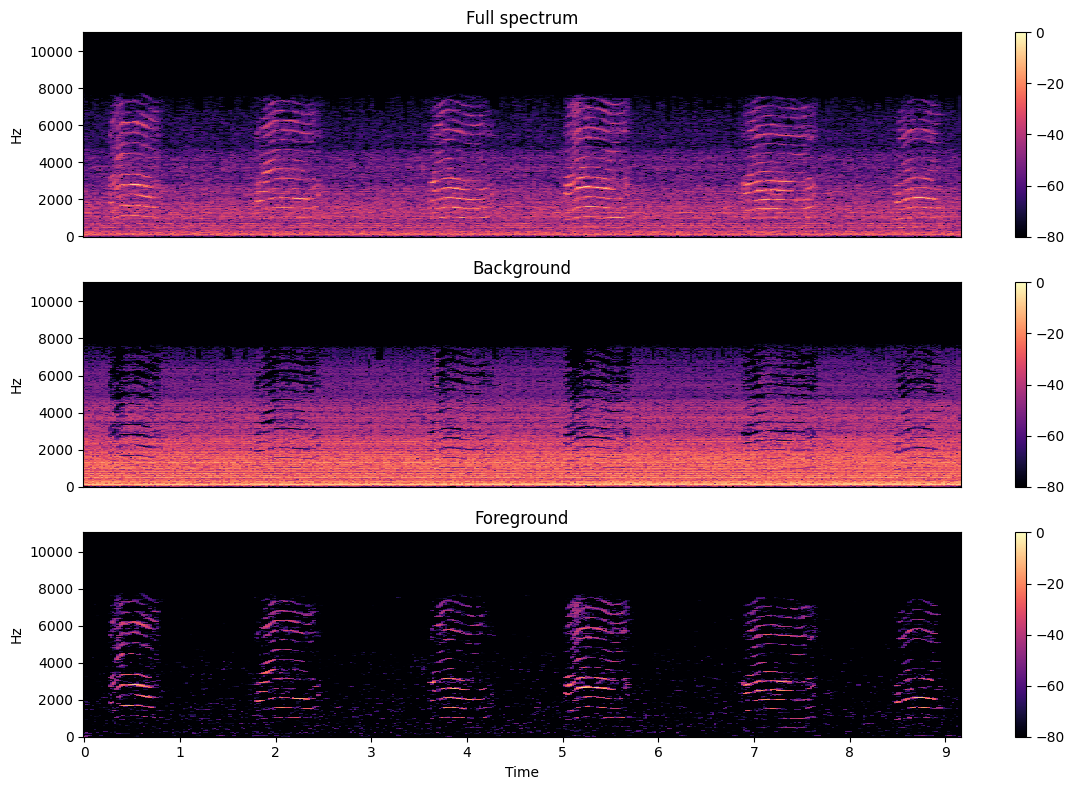

In [44]:
#데이터의 유의미한 음성과 배경 분리해 보기

S_full, phase = librosa.magphase(librosa.stft(y)) #speech processing에 n_fft=512 권장된다고는함



# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components
S_foreground = mask_v * S_full
S_background = mask_i * S_full
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full, ref=np.max),
                         y_axis='hz', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background, ref=np.max),
                         y_axis='hz', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground, ref=np.max),
                         y_axis='hz', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()

배경 노이즈가 제거된 순수한 데이터를 얻어낼 수 있었다.

고양이 울음소리의 Spectrogram은 어떻게 생겼는지도 이를 통해 알아볼 수 있었다. 1.5초 미만의 길이로 나타나며, 직선이 여러 개 높은 주파수 영역대까지 쌓인 형태로 나타난다.

그렇다면 배경이 제거된 데이터에서 소리의 피크를 찾아 보면 어떻게 될까?


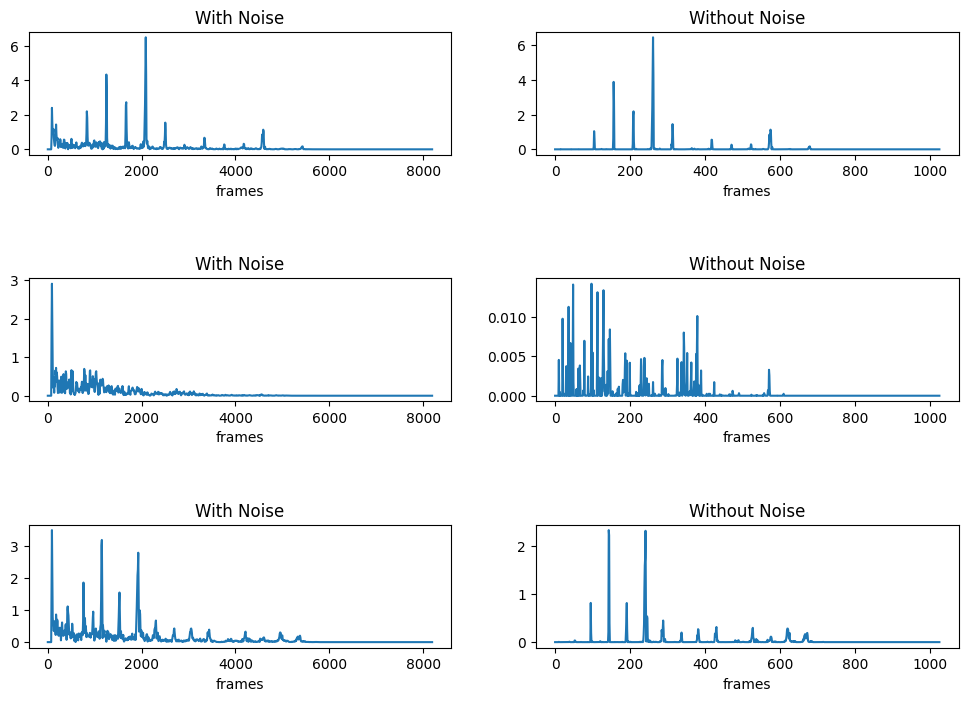

In [54]:
FREQ_MIN = 10

def get_timeslice(t, with_noise = False):
    S_arr=S_full if with_noise else S_foreground
    tslice=S_arr[:,librosa.time_to_frames(t,sr=sr)] #0보다 약간 큰 쪽에 피크 있음 -> 제거
    tslice[:FREQ_MIN] = 0
    return tslice

tlst = [0.5, 1.5, 5.5]

plt.figure(figsize=(12,8))
plt.subplots_adjust(hspace=1)
for i in range(len(tlst)): #모든 리스트 안의 시간에 대해
    t=tlst[i]
    plt.subplot(len(tlst),2,1+i*2)
    plt.title("With Noise")
    plt.xlabel("frames")
    plt.plot(np.linspace(0, 8192, 1025),get_timeslice(t, True)) #한 시간의 데이터를 플롯
    plt.subplot(len(tlst),2,2+i*2)
    plt.title("Without Noise")
    plt.xlabel("frames")
    plt.plot(get_timeslice(t, False)) #한 시간의 데이터를 플롯

Noise가 없으니 더 세밀하게 데이터를 바라볼 수 있다는 것을 알게 되었다.


sr은 sampling rate -> time & 열 인덱스 관계를 결정하고, frequncy & 행 인덱스 관계를 결정한다.

피크를 찾기 위해 필요한 것들은
1. 최소 Threshold. 적어도 1 넘는 값들만 볼 필요가 있음.
2. 노이즈 제거.


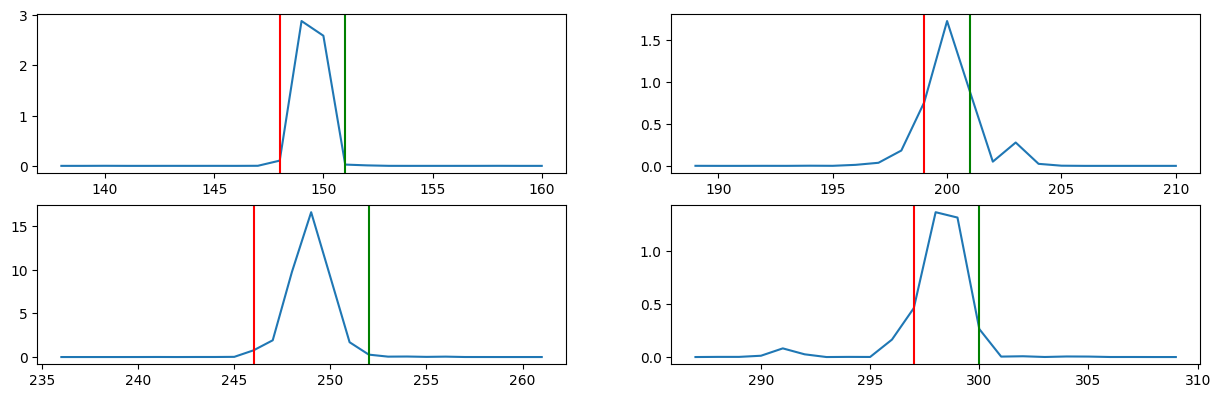

In [57]:
'''
전략: Threshold보다 작았다가 커지는거 탐지 & 커졌다가 작아지는거 탐지 -> 피크의 시작/끝 탐지해보자
numpy 함수들로 구현하는게 관건
'''
THRESHOLD = 1
PEAK_MAX_NUM = 5

def find_peaks(arr : np.ndarray): #진폭이 커지는 부분과 작아지는 부분을 찾아냄
    diff=np.diff(np.sign(arr-THRESHOLD))
    rising = np.where(diff==2)[0]
    rising = np.concatenate([rising, np.zeros(shape=(PEAK_MAX_NUM,))])[:PEAK_MAX_NUM]

    falling = np.where(diff==-2)[0]+1
    falling = np.concatenate([falling, np.zeros(shape=(PEAK_MAX_NUM,))])[:PEAK_MAX_NUM]

    return np.vstack([rising, falling])

tslice=get_timeslice(5.3)
peakarr = find_peaks(tslice).astype(int) #피크를 찾아서 저장

plt.figure(figsize=(15,12))
for i in range(peakarr.shape[1]): #찾아낸 모든 피크를 플롯함, 올라가는 부분을 빨간 선, 내려가는 부분을 초록 선으로 표시
    r,f = tuple(peakarr[:,i])
    if r==0:
        continue
    delta = 10
    plt.subplot(5,2,i+1)
    plt.plot(np.arange(r-delta,f+delta), tslice[r-delta:f+delta])
    plt.axvline(x=r, c='r')
    plt.axvline(x=f, c='g')
    

이제 피크를 찾을 수 있게 되었다.

피크에 대해 필요한 정보는 무엇이 있을까?
1) 위치
2) 너비? (이건 큰 의미 없을 듯. frequency 간격이 너무 넓기 때문)
3) 높이 
--> 위치와 높이만 필요

이 둘을 추출해 보자.

In [64]:
def ctft_to_peaks(carr : np.ndarray, threshold = 1, max_peak_num = 10): #ctft된 Spectrogram data에서 피크를 모두 찾는 함수
    rising = np.zeros(shape=(max_peak_num, carr.shape[1]))
    falling = np.zeros(shape=(max_peak_num , carr.shape[1]))
    diff=np.diff(np.sign(carr.T-threshold), axis = 1)

    for arr, num in [(rising, 2), (falling, -2)]: #올라가는 부분과 내려가는 부분을 찾음
        a,b = np.where(diff==num)
        for i in range(diff.shape[0]):
            temp=b[a==i]
            minlen = min(max_peak_num, len(temp))
            arr[:minlen,i]=temp[:minlen]

    return (rising, falling)

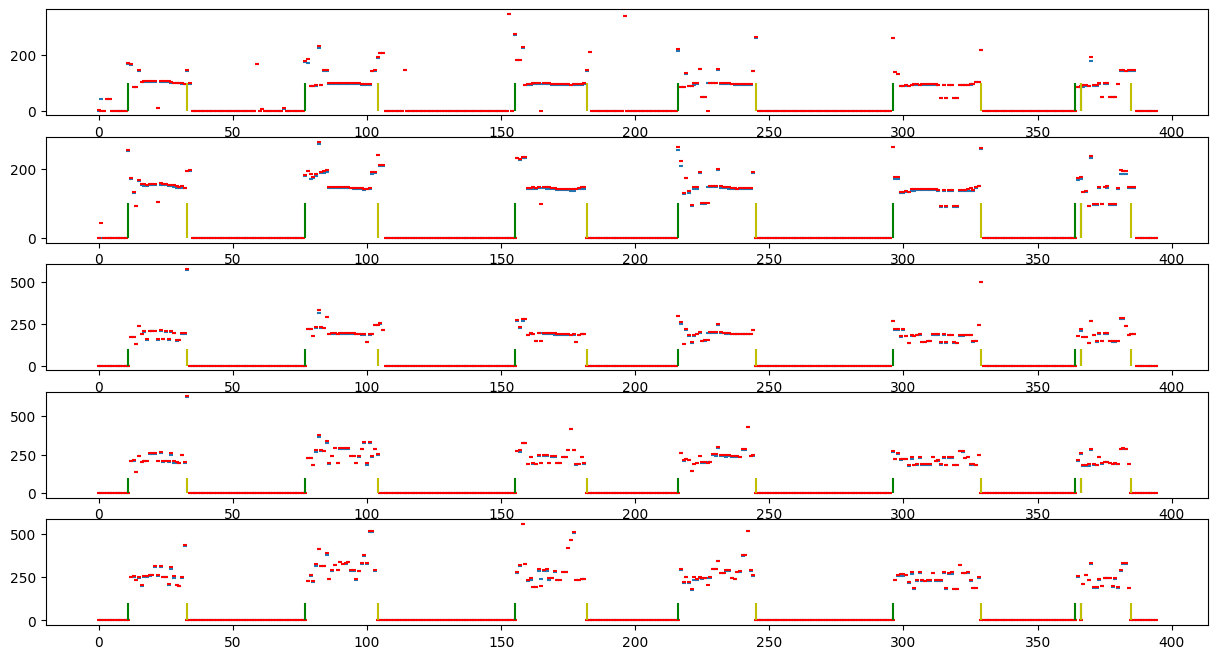

In [65]:
rising, falling = ctft_to_peaks(S_foreground, threshold=0.1, max_peak_num=5) #피크를 모두 찾은 뒤

x=np.arange(0, rising.shape[1],1/1).astype(int)
plt.figure(figsize=(15,8))

#의미있는 부분만 잘라내기
cnt_mat = (rising > 1e-5).sum(axis=0)
thres = 5 - 0.5
cutpoint_rising = np.where(np.diff(np.sign(cnt_mat-thres))==2)[0] #올라가는 점의 리스트
cutpoint_falling = np.where(np.diff(np.sign(cnt_mat-thres))==-2)[0]+1 #내려가는 점의 리스트
if(cnt_mat[0] > thres): #맨 앞 점 끼워넣기
    cutpoint_rising = np.insert(0,0,cutpoint_rising)

for i in range(5): #주파수 대역에 따라 다른 그래프로 시각화
    rising_2 = rising[i,:]
    falling_2 = falling[i,:]
    plt.subplot(5,1,i+1)
    plt.scatter(x[:], rising_2[:], s=10, marker='_')
    plt.scatter(x[:], falling_2[:], s=10, marker='_', c='r')
    plt.vlines(x=cutpoint_rising, ymin=0, ymax= 100,color='g')
    plt.vlines(x=cutpoint_falling, ymin=0, ymax= 100,color='y')

주파수별 피크를 모두 얻었다. 제대로 얻어졌는지 판단하기 위해 모든 주파수 영역대를 합쳐서 시각화해 보자.

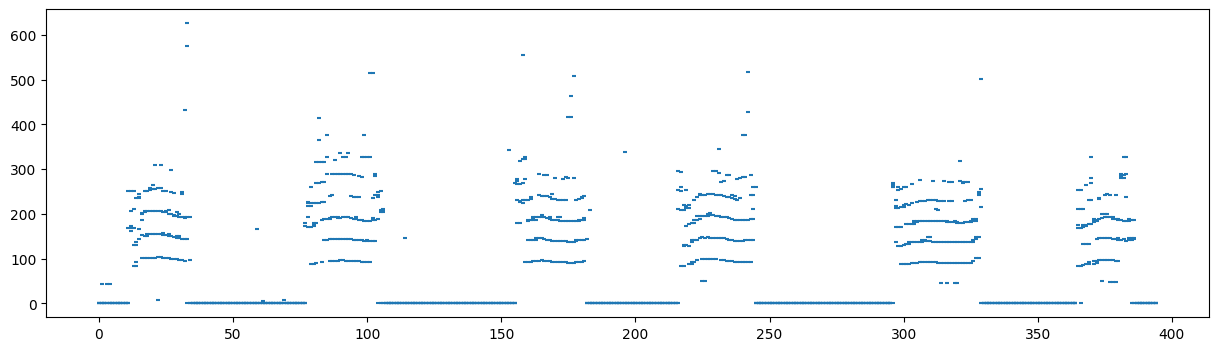

In [63]:
x=np.arange(0, rising.shape[1],0.2).astype(int)
plt.figure(figsize=(15,4))
plt.scatter(x, rising.T.flatten(), s=10, marker='_')

위에서 본 Spectrogram에서 깔끔하게 얻어진 피크들의 그래프를 볼 수 있다.

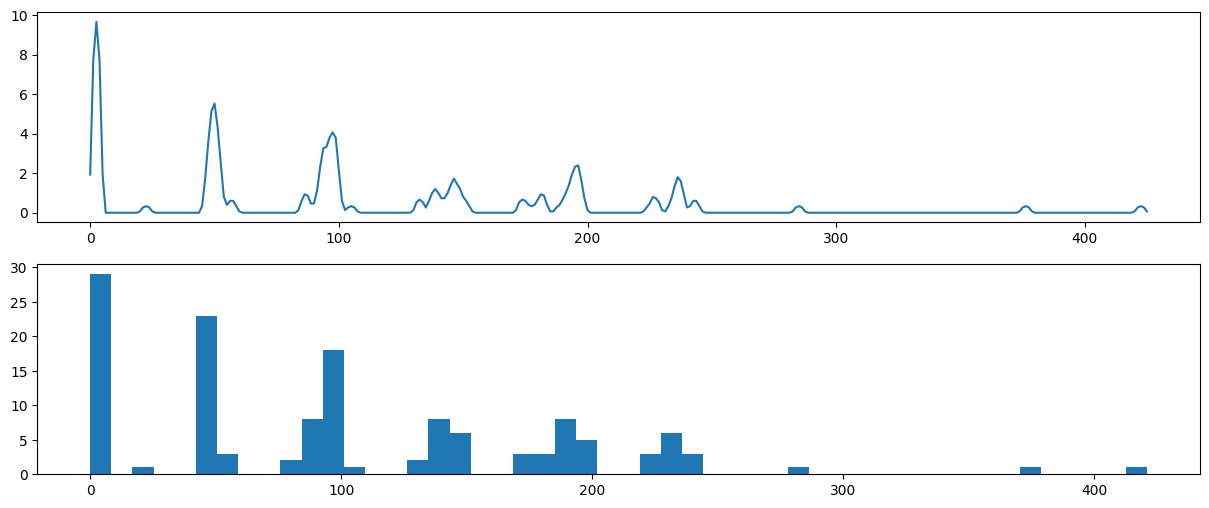

In [66]:
plt.figure(figsize=(15,6))

i=1
a,b=cutpoint_rising[i], cutpoint_falling[i]

#히스토그램처럼 각 frequency가 몇번씩 나왔는지 세줌.
scale = 0.8
new = rising[:,a:b]-np.min(rising[:,a:b],axis=0)
temp = (new.flatten() * scale).astype(int)
elem, counts = np.unique(temp, return_counts=True)
temp2 = np.zeros(shape = (np.max(elem)+1,))
temp2[elem] = counts

#매끄럽게
filter = np.array([1,4,5,4,1])
filter = filter / sum(filter)
temp2 = np.convolve(temp2, filter)

#앞에서 구한거 플롯
plt.subplot(2,1,1)
plt.plot(np.arange(np.max(elem)+1 + len(filter) - 1)/scale, temp2)
plt.subplot(2,1,2)
#비교용으로 히스토그램도 플롯. 둘이 대충 비슷하면 성공한거
plt.hist(new.flatten(), bins = 50)
plt.show()

이를 이용하면 각각의 주파수에 대한 피크 값도 추출할 수 있을 듯 하다.

**비정형 데이터에서 정형 데이터 추출**

위에서 본 MFCC 데이터를 비정형 데이터로부터 추출한다. (비정형 데이터와 다른 데이터셋)

In [2]:
#고양이 음성 파일 위치 불러오기
base_dir = '/catclass/augmented_data/structured_data/train/caterwaul/'
train_folder = glob(base_dir)
train_path = []
for folder in train_folder:
    tmp = glob(folder + '/*')
    train_path += tmp

In [76]:
li = []
for i in range(len(train_path)):
    y,sr = librosa.load(train_path[i])
    mfccs = librosa.feature.mfcc(y=y,sr=sr)
    #mfcc의 평균을 구한 후 리스트에 어펜드
    mean_mfccs = np.mean(mfccs, axis=1)[1:]
    li.append(mean_mfccs)
    if i%100==0:
        print(i)
df = pd.DataFrame(li)
df.to_csv("/catclass/augmented_data/structured_data/train/meow/caterwaul.csv")

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600


**정형 데이터 EDA**

In [3]:
#dataframe 불러오기
df_meow = pd.read_csv("/catclass/augmented_data/structured_data/train/meow/meow.csv").iloc[:,1:]
df_caterwaul = pd.read_csv("/catclass/augmented_data/structured_data/train/caterwaul/caterwaul.csv").iloc[:,1:]

Meow, Caterwaul의 head, shape, info, describe

In [14]:
df_meow.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,148.97668,-51.709938,75.362750,-47.673800,25.923391,-36.307580,10.871811,-15.230599,-3.411929,-1.713140,-10.433668,0.815263,-19.103000,4.101674,-4.231682,9.518656,-14.844532,8.433763,9.850194
1,171.46198,-44.638890,18.681830,26.157013,-22.517303,15.533758,22.504488,0.568935,6.506436,3.454565,10.232184,13.633137,-7.442061,2.969222,18.966692,5.879837,14.652749,19.062252,-2.040156
2,180.25370,-44.408940,41.582188,34.521080,24.515460,-24.470562,13.305822,21.454735,-5.628762,-0.679444,-7.189687,4.194264,-4.838626,12.780309,11.190937,0.245481,1.496121,-20.160686,-13.175027
3,199.35022,-103.836350,70.203200,33.758440,-27.126930,45.811085,6.588595,-4.489926,16.769041,-4.106375,13.885373,9.383706,-15.307931,3.808329,8.990068,-6.472169,-3.520761,5.240314,9.190849
4,216.35930,-61.750300,8.161021,39.758957,-27.103483,5.492200,17.222095,-11.504082,12.811937,14.190342,-3.081301,9.612517,0.279400,-6.427592,11.040759,4.211536,3.098168,16.241661,3.866039


In [10]:
df_meow.shape

(8681, 19)

In [5]:
df_meow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8681 entries, 0 to 8680
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       8681 non-null   float64
 1   1       8681 non-null   float64
 2   2       8681 non-null   float64
 3   3       8681 non-null   float64
 4   4       8681 non-null   float64
 5   5       8681 non-null   float64
 6   6       8681 non-null   float64
 7   7       8681 non-null   float64
 8   8       8681 non-null   float64
 9   9       8681 non-null   float64
 10  10      8681 non-null   float64
 11  11      8681 non-null   float64
 12  12      8681 non-null   float64
 13  13      8681 non-null   float64
 14  14      8681 non-null   float64
 15  15      8681 non-null   float64
 16  16      8681 non-null   float64
 17  17      8681 non-null   float64
 18  18      8681 non-null   float64
dtypes: float64(19)
memory usage: 1.3 MB


In [8]:
df_meow.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000,8681.000000
mean,176.410230,-69.932654,28.320945,8.316400,-8.839973,1.121343,12.705243,-7.968154,4.328496,1.246938,-4.329796,6.955136,-4.482944,1.863797,4.778590,4.737510,0.246220,5.466487,-0.037000
std,40.275268,29.548497,29.996615,26.311038,25.028477,18.423224,12.268588,10.425017,10.372888,9.065160,9.335366,9.127743,9.467317,8.574557,10.870094,8.197651,8.001727,8.393860,7.452332
min,-28.553198,-199.544450,-80.702270,-90.333640,-72.304450,-74.154350,-43.610460,-49.394608,-44.419384,-38.615845,-36.028600,-36.797490,-43.550137,-35.209290,-41.666320,-30.423592,-39.499146,-40.468880,-39.104580
25%,154.411740,-85.451060,9.105461,-9.639549,-27.873762,-11.770164,5.578515,-14.454002,-1.893598,-4.096895,-10.480704,1.594075,-10.479208,-3.468128,-2.391386,-0.591898,-4.468263,0.443758,-4.087538
50%,184.701640,-67.982850,27.428715,13.466567,-14.689854,4.916238,14.745817,-8.499935,5.456260,1.579532,-4.500747,7.743545,-4.070269,1.639055,5.776214,4.944362,0.681032,6.606595,0.310106
75%,204.301150,-54.189250,50.201653,29.976898,10.441035,13.975767,21.181032,-2.638418,10.757915,6.750549,1.101401,12.661027,1.629805,6.807671,12.835444,10.122531,5.330832,11.315249,4.407038
max,269.591580,93.306420,118.958725,69.425250,76.842600,60.315224,56.695923,47.289770,49.278250,58.239162,54.281860,46.234997,41.150124,49.358425,46.805153,45.572807,31.381664,30.288763,31.433311


In [18]:
df_meow.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
dtype: int64

Meow 데이터에는 결측치가 없다.

In [15]:
df_caterwaul.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,205.39860,-103.69094,6.207486,33.718560,-32.116566,17.043615,24.657140,6.349641,23.318176,5.279308,-1.687714,9.283962,-2.884589,2.986375,11.336090,0.067466,5.591072,11.745068,2.966687
1,205.39860,-103.69094,6.207486,33.718560,-32.116566,17.043615,24.657140,6.349641,23.318176,5.279308,-1.687714,9.283962,-2.884589,2.986375,11.336090,0.067466,5.591072,11.745068,2.966687
2,139.87347,-79.66340,50.715355,-15.572526,27.152693,-21.569923,24.797922,9.945320,2.205587,10.388972,-14.062648,5.493455,-5.101165,11.707581,0.034978,5.181710,3.301609,4.938314,2.747216
3,207.49790,-77.59814,15.943235,44.663414,-29.027521,10.851999,23.504300,-3.599335,14.366628,5.164755,-6.008141,9.778302,-0.060158,1.245284,16.650180,6.365073,8.580484,17.264193,4.357121
4,199.11832,-43.01693,37.277138,9.707655,14.015252,-6.804242,17.587248,15.841443,1.096617,9.842384,-10.412914,1.263091,0.498261,6.876920,5.080964,1.015308,6.309715,3.709884,3.298363


In [11]:
df_caterwaul.shape

(10617, 19)

In [12]:
df_caterwaul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10617 entries, 0 to 10616
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10617 non-null  float64
 1   1       10617 non-null  float64
 2   2       10617 non-null  float64
 3   3       10617 non-null  float64
 4   4       10617 non-null  float64
 5   5       10617 non-null  float64
 6   6       10617 non-null  float64
 7   7       10617 non-null  float64
 8   8       10617 non-null  float64
 9   9       10617 non-null  float64
 10  10      10617 non-null  float64
 11  11      10617 non-null  float64
 12  12      10617 non-null  float64
 13  13      10617 non-null  float64
 14  14      10617 non-null  float64
 15  15      10617 non-null  float64
 16  16      10617 non-null  float64
 17  17      10617 non-null  float64
 18  18      10617 non-null  float64
dtypes: float64(19)
memory usage: 1.5 MB


In [13]:
df_caterwaul.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000,10617.000000
mean,199.337677,-72.206876,29.297736,20.482745,-6.434471,-1.158614,21.836596,4.396877,9.822247,7.874699,-9.138762,6.980390,-1.824104,4.331056,9.333566,3.762075,5.532161,11.073010,3.570528
std,28.524817,17.527221,22.253098,21.991516,21.918732,14.536647,5.496095,6.825837,9.085340,2.322983,6.363264,3.365832,3.286369,4.123829,6.017042,2.820191,2.004811,5.023684,1.406163
min,75.062480,-164.035980,-72.958570,-87.006010,-77.559840,-48.957165,-31.910177,-29.642048,-40.557762,-21.877466,-33.362007,-16.125591,-25.678268,-23.579681,-28.138666,-25.400688,-17.285740,-8.323215,-14.489716
25%,174.477540,-79.663400,6.207486,-2.212271,-29.027521,-12.634703,17.587248,-2.178029,1.096617,5.279308,-14.062648,5.035295,-5.101165,0.934714,3.334001,1.015308,4.014265,4.938314,2.922192
50%,205.398600,-73.962250,21.048964,22.068390,-19.779451,3.030261,23.504300,1.038503,6.083187,8.120633,-6.008141,7.142205,-1.974055,2.986375,9.824415,4.784276,5.591072,10.945308,3.053233
75%,215.593170,-58.785168,50.715355,37.130570,14.015252,10.922730,24.797922,9.736518,17.155128,9.389696,-2.484642,9.778302,0.498261,6.876920,12.330917,6.365073,6.309715,12.729613,4.357121
max,257.659360,21.929491,91.123870,61.413902,48.917010,33.481857,41.848240,30.193250,25.341300,27.695185,26.659452,26.834486,29.336283,24.825940,23.351357,22.478292,14.103569,20.399920,21.393280


In [17]:
df_caterwaul.isna().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    0
dtype: int64

Caterwaul 데이터에는 결측치가 없다.

Meow에 이상값이 있는지 판단하자.

In [113]:
meow_arr = df_meow.__array__()
meow_arr.shape

(8681, 19)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb0c2ee3b80>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb0c2f0c100>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb0c2ee38e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb0c2f0c640>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb0c2f0c8e0>],
 'means': []}

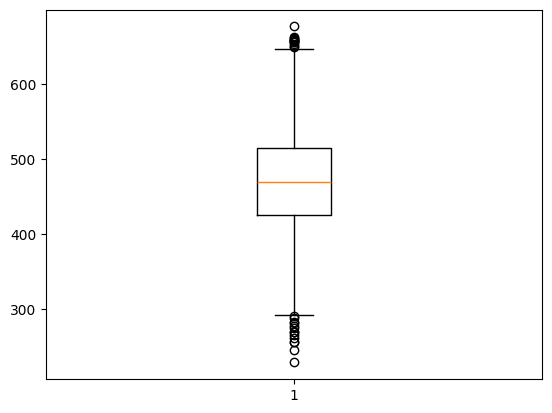

In [115]:
err_array = np.sum(np.abs(meow_arr - np.average(meow_arr)), axis = 1) #전체 값의 합에 대한 오차 (박스플롯)
plt.boxplot(err_array)

가장 오차가 큰 데이터를 찾아보자.

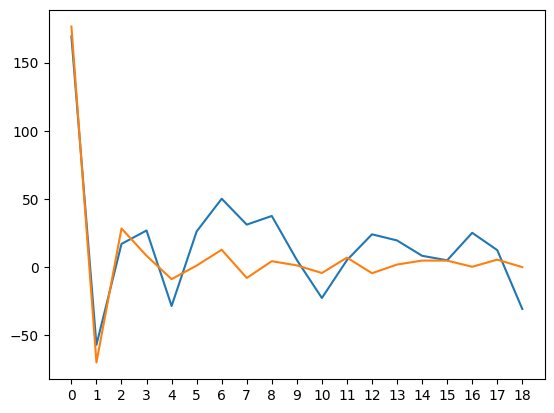

In [139]:
plt.plot(df_meow[np.sum(np.abs(stats.zscore(df_meow))>3, axis=1)>=6].iloc[0,:])
plt.plot(df_meow.mean())

결측치를 제외한 데이터를 찾는다.

In [149]:
df_meow_new = df_meow[(np.abs(stats.zscore(df_meow))<3).all(axis=1)]
df_meow_new

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,148.97668,-51.709938,75.362750,-47.673800,25.923391,-36.307580,10.871811,-15.230599,-3.411929,-1.713140,-10.433668,0.815263,-19.103000,4.101674,-4.231682,9.518656,-14.844532,8.433763,9.850194
1,171.46198,-44.638890,18.681830,26.157013,-22.517303,15.533758,22.504488,0.568935,6.506436,3.454565,10.232184,13.633137,-7.442061,2.969222,18.966692,5.879837,14.652749,19.062252,-2.040156
3,199.35022,-103.836350,70.203200,33.758440,-27.126930,45.811085,6.588595,-4.489926,16.769041,-4.106375,13.885373,9.383706,-15.307931,3.808329,8.990068,-6.472169,-3.520761,5.240314,9.190849
4,216.35930,-61.750300,8.161021,39.758957,-27.103483,5.492200,17.222095,-11.504082,12.811937,14.190342,-3.081301,9.612517,0.279400,-6.427592,11.040759,4.211536,3.098168,16.241661,3.866039
5,179.52351,-43.678974,25.193232,15.571154,-13.108270,4.003244,20.246320,-2.685353,0.770110,5.206519,3.727935,9.306947,-0.084326,4.249782,12.860862,13.191605,6.120707,11.786963,6.882188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8675,188.30191,-56.095238,13.957223,41.009335,-29.758284,2.758763,28.705975,-2.367443,3.194740,8.871480,2.233042,9.644005,2.135757,0.367714,11.628251,6.356226,12.325340,19.310324,-0.433715
8676,233.20152,-52.521473,29.728296,0.899056,-4.898423,8.941235,-23.673735,-5.866722,-1.745516,-7.313325,-15.231792,-10.937415,7.247839,-2.857565,1.451962,-0.941044,-9.842803,4.259428,4.674977
8677,79.22532,-88.770930,45.302624,-35.673800,18.549707,-19.377403,16.395504,-17.430038,-9.929862,-7.516968,-16.462860,-5.978959,-14.220096,15.215513,2.461714,9.923130,-10.644952,-6.772065,-6.731790
8678,164.25966,-71.923935,65.888210,-7.716682,9.085968,-12.579560,2.945799,-7.210678,-1.319161,-7.158673,-0.475821,-1.281677,-8.316510,1.153664,-6.097403,27.053493,-4.183150,3.853392,-0.536650


Caterwaul에 이상값이 있는지 찾아보자.

In [140]:
caterwaul_arr = df_meow.__array__()
caterwaul_arr.shape

(8681, 19)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fb0c2717eb0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb0c2734430>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb0c2717c10>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb0c2734970>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb0c2734c10>],
 'means': []}

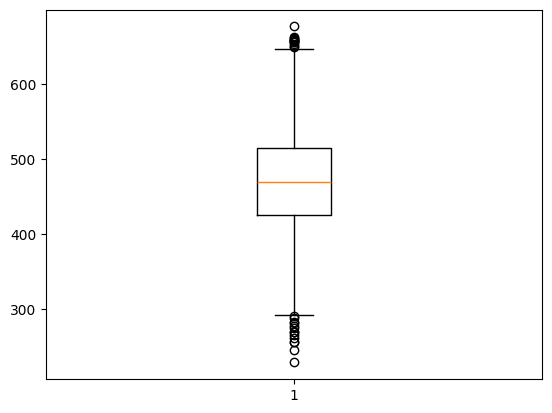

In [141]:
err_array = np.sum(np.abs(caterwaul_arr - np.average(caterwaul_arr)), axis = 1) #전체 값의 합에 대한 오차 (박스플롯)
plt.boxplot(err_array)

가장 오차가 큰 데이터를 찾아보자.

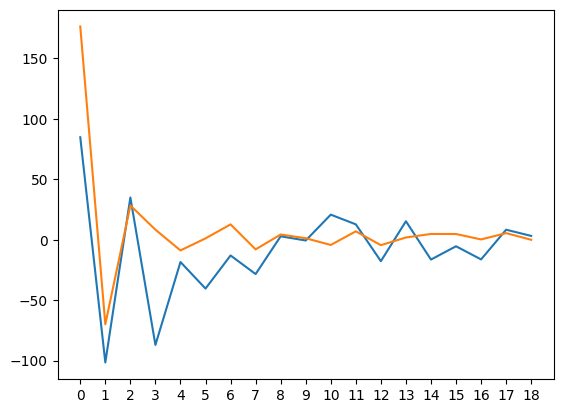

In [148]:
plt.plot(df_caterwaul[np.sum(np.abs(stats.zscore(df_caterwaul))>3, axis=1)>=10].iloc[0,:])
plt.plot(df_meow.mean())

결측치를 제외한 데이터를 찾는다.

In [150]:
df_caterwaul_new = df_caterwaul[(np.abs(stats.zscore(df_caterwaul))<3).all(axis=1)]
df_caterwaul_new

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,205.39860,-103.690940,6.207486,33.718560,-32.116566,17.043615,24.657140,6.349641,23.318176,5.279308,-1.687714,9.283962,-2.884589,2.986375,11.336090,0.067466,5.591072,11.745068,2.966687
1,205.39860,-103.690940,6.207486,33.718560,-32.116566,17.043615,24.657140,6.349641,23.318176,5.279308,-1.687714,9.283962,-2.884589,2.986375,11.336090,0.067466,5.591072,11.745068,2.966687
2,139.87347,-79.663400,50.715355,-15.572526,27.152693,-21.569923,24.797922,9.945320,2.205587,10.388972,-14.062648,5.493455,-5.101165,11.707581,0.034978,5.181710,3.301609,4.938314,2.747216
3,207.49790,-77.598140,15.943235,44.663414,-29.027521,10.851999,23.504300,-3.599335,14.366628,5.164755,-6.008141,9.778302,-0.060158,1.245284,16.650180,6.365073,8.580484,17.264193,4.357121
4,199.11832,-43.016930,37.277138,9.707655,14.015252,-6.804242,17.587248,15.841443,1.096617,9.842384,-10.412914,1.263091,0.498261,6.876920,5.080964,1.015308,6.309715,3.709884,3.298363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10612,207.49790,-77.598140,15.943235,44.663414,-29.027521,10.851999,23.504300,-3.599335,14.366628,5.164755,-6.008141,9.778302,-0.060158,1.245284,16.650180,6.365073,8.580484,17.264193,4.357121
10613,236.65007,-56.288265,1.272174,37.130570,-19.997023,11.484669,29.623394,9.736518,19.170862,9.360277,-2.484642,7.142205,-0.073727,0.934714,11.356770,2.400912,4.014265,12.446684,4.020939
10614,139.87347,-79.663400,50.715355,-15.572526,27.152693,-21.569923,24.797922,9.945320,2.205587,10.388972,-14.062648,5.493455,-5.101165,11.707581,0.034978,5.181710,3.301609,4.938314,2.747216
10615,205.39860,-103.690940,6.207486,33.718560,-32.116566,17.043615,24.657140,6.349641,23.318176,5.279308,-1.687714,9.283962,-2.884589,2.986375,11.336090,0.067466,5.591072,11.745068,2.966687


데이터의 평균을 내어 비교해 보자.

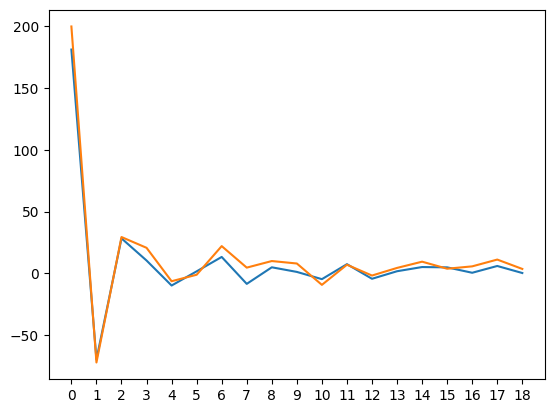

In [151]:
plt.plot(df_meow_new.mean())
plt.plot(df_caterwaul_new.mean())

데이터의 표준편차를 계산해 보자.

In [153]:
df_meow_new.std()

0     36.094662
1     27.436700
2     28.986890
3     25.118593
4     24.688972
5     17.698446
6     11.123333
7      9.030552
8      9.149427
9      7.917719
10     8.284708
11     8.135482
12     8.597206
13     7.696897
14    10.317406
15     7.708125
16     7.218767
17     7.732733
18     6.502329
dtype: float64

In [154]:
df_caterwaul_new.std()

0     28.055789
1     16.841479
2     22.017637
3     21.833261
4     21.796983
5     14.459588
6      4.985561
7      6.436035
8      8.983452
9      1.872915
10     6.174457
11     3.171785
12     2.948910
13     3.946431
14     5.866709
15     2.585952
16     1.525617
17     4.949982
18     0.858030
dtype: float64

오차 막대를 포함해 그래프를 그려 보자.

<ErrorbarContainer object of 3 artists>

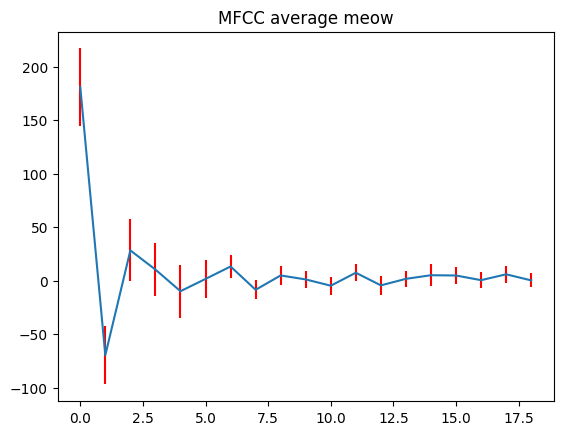

In [155]:
plt.title("MFCC average meow")
plt.errorbar(x=np.arange(19),y=df_meow_new.mean(), yerr=df_meow_new.std(),ecolor='r')

<ErrorbarContainer object of 3 artists>

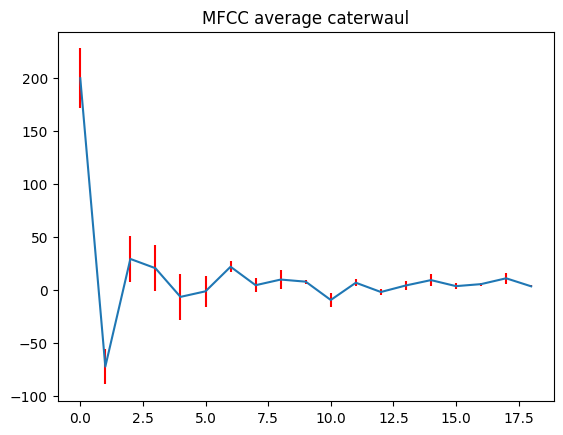

In [156]:
plt.title("MFCC average caterwaul")
plt.errorbar(x=np.arange(19),y=df_caterwaul_new.mean(), yerr=df_caterwaul_new.std(),ecolor='r')

MFCC의 표준편차가 뒤로 갈수록 작아지며, 앞부분에서도 크지 않은 것을 볼 수 있다.

MFCC의 평균의 상관계수를 구해 보자.

<Axes: >

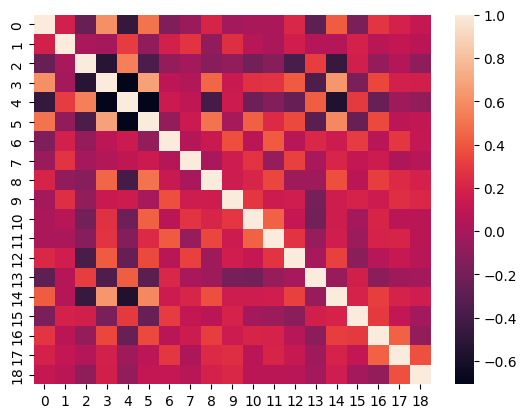

In [157]:
sns.heatmap(df_meow_new.corr())

<Axes: >

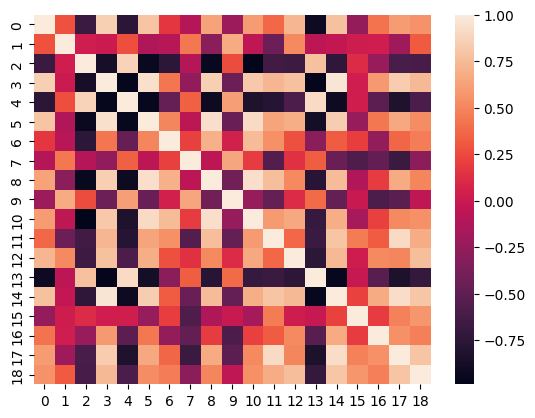

In [158]:
sns.heatmap(df_caterwaul_new.corr())

두 데이터의 양상이 확연히 다른 것을 볼 수 있다.